In [1]:
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] --upgrade
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.3 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


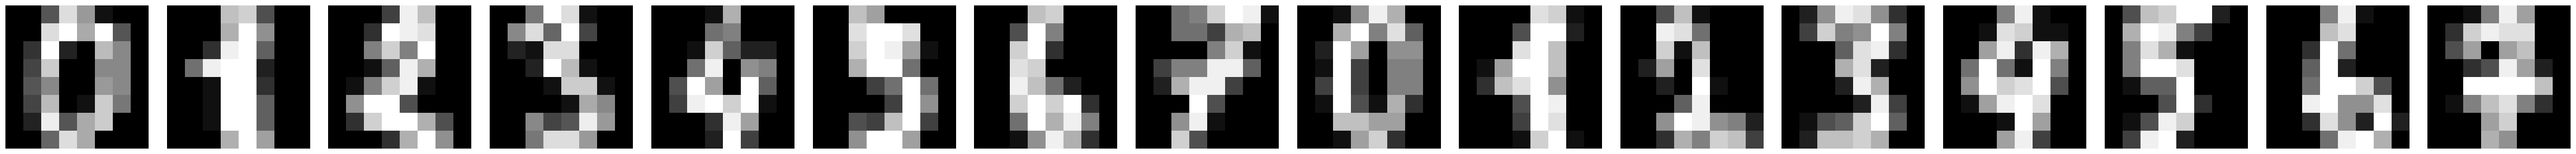

In [3]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]
labels = labels[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]

fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(16*3,3))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8, 8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [4]:
def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    features = features[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]
    labels = labels[np.where((labels == 0) | (labels == 1)|(labels == 2) | (labels == 3)|(labels == 4) | (labels == 5)|(labels == 6) | (labels == 7))]

    # rescale data
    features = features / 16.0
    # reshape
    features = features.reshape(-1, 8, 8)
    # Transform into a Hermitian matrix
    features = np.array([(img+img.T)/2 for img in features])

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )

In [5]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==8 and img.shape[-2] == 8, f"The shape of the image must be 8 by 8, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2,
        10
        )
    )

[[ 0.52280899-0.05345201j -0.02012155-0.26802134j -0.01370825+0.09338635j
  -0.2928303 -0.26538394j -0.18970313-0.06420587j  0.2587725 +0.22512408j
   0.19907107-0.16207312j -0.51112755-0.03980056j]
 [-0.02012155-0.26802134j  0.53214286+0.21277722j -0.12639032+0.12245572j
   0.05908119-0.15241347j -0.27790381+0.05520424j  0.0465508 -0.4960972j
   0.18444435-0.32981774j  0.04401798-0.26138985j]
 [-0.01370825+0.09338635j -0.12639032+0.12245572j  0.40941461-0.70503717j
   0.06773457-0.26724076j  0.04424185+0.24340596j -0.05640243-0.02605337j
   0.16318621-0.35578976j -0.03296604-0.00715265j]
 [-0.2928303 -0.26538394j  0.05908119-0.15241347j  0.06773457-0.26724076j
   0.31491764-0.16401045j -0.06864561-0.19646311j  0.42094601-0.06673045j
  -0.37334171+0.31789562j -0.3377229 -0.18859031j]
 [-0.18970313-0.06420587j -0.27790381+0.05520424j  0.04424185+0.24340596j
  -0.06864561-0.19646311j  0.66624915-0.35876976j  0.02846178-0.25246009j
   0.15392837-0.24798376j -0.16901028-0.15554525j]
 [ 0.2

In [6]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

observables_8_dim = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      basis_state = tensor_product(*[ket[i], ket[j], ket[k]])
      idx = int(i+j+k, 2)
      observables_8_dim[idx] = jnp.outer(basis_state, basis_state)

print(pauli_words_su4.keys())
test_params = jnp.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
print(
    jnp.einsum(
        "i, ijk -> jk",
        test_params,
        jnp.asarray(list(pauli_words_su4.values()))
    )
)

dict_keys(['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'])
[[ 30. +0.j  14.-16.j  11.-19.j  -5.-15.j]
 [ 14.+16.j  -6. +0.j  15. -3.j  -3. +3.j]
 [ 11.+19.j  15. +3.j -24. +0.j -12.+12.j]
 [ -5.+15.j  -3. -3.j -12.-12.j   0. +0.j]]


In [7]:
def su4_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk -> jk", params, jnp.asarray(list(pauli_words_su4.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[15], key=jrng_key)
print(su4_op(test_params))
print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su4_op(test_params))),
        su4_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su4_op(test_params),
        jnp.transpose(jnp.conjugate(su4_op(test_params)))
    )
)

[[ 0.18175111+0.14237464j -0.19109383+0.13848737j -0.75200203+0.33751301j
   0.11916688+0.44427193j]
 [ 0.34991553+0.1286837j   0.6067486 -0.02543435j  0.01445637-0.40064771j
   0.50409921+0.27814613j]
 [-0.1659981 -0.3426707j  -0.52691953-0.23243043j  0.27301896-0.17265138j
   0.39882079+0.50985042j]
 [-0.72090804+0.37816483j  0.29208795-0.39815847j -0.0471504 +0.23082313j
   0.14572205+0.12922858j]]
[[ 1.00000000e+00+1.81701793e-17j -2.17690136e-16+1.44718640e-16j
  -1.97497862e-16+2.03006957e-16j  6.60316545e-17-1.11555849e-16j]
 [-2.17690136e-16-1.44271312e-16j  1.00000000e+00+1.08735876e-17j
  -1.91627223e-16+4.85513313e-16j -2.39153754e-16-2.52312274e-16j]
 [-1.97497862e-16-2.01870302e-16j -1.91627223e-16-4.77796251e-16j
   1.00000000e+00+2.63288753e-18j -3.05125821e-16-3.12503901e-16j]
 [ 6.60316545e-17+1.13308790e-16j -2.39153754e-16+2.65372088e-16j
  -3.05125821e-16+3.38679491e-16j  1.00000000e+00+2.41740471e-19j]]
[[ 1.00000000e+00+4.44992099e-18j  5.31968585e-16+8.38337340e-

In [8]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

In [9]:
def su4_layer_3q(
    params:jnp.ndarray
):
  """
  A three-qubit parameterized layer
  made up by two su4 gates
  one on qubit pair (1,2)
  the other one on (2,3)
  """
  first = tensor_product(
      su4_op(params[:15]),
      multi_qubit_identity(1)
  )
  second = tensor_product(
      multi_qubit_identity(1),
      su4_op(params[:15])
  )

  return jnp.dot(second, first)


def qnn_hamevo(
    su4_params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for su4 gates
  and output an array of 8 elements representing classification logits
  """
  n_layers = len(su4_params)//30

  state = tensor_product(ket['+'], ket['+'], ket['+'])

  for i in range(n_layers):
    state = jnp.dot(img_hermitian_evolve(img, t[i]), state)
    state = jnp.dot(
        su4_layer_3q(su4_params[30*i: 30*(i+1)]),
        state
    )

  return vmap_measure_sv(state, jnp.asarray(observables_8_dim))

print(
    qnn_hamevo(
        jax.random.normal(shape=[30*30], key=jrng_key),
        jax.random.normal(shape=[30], key=jrng_key),
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2
    )
)
print(jnp.sum(
    qnn_hamevo(
        jax.random.normal(shape=[30*30], key=jrng_key),
        jax.random.normal(shape=[30], key=jrng_key),
        (images[0].reshape((8, 8))/16+images[0].reshape((8, 8)).T/16)/2
    )
))

[0.05179166 0.06989755 0.12196543 0.22654106 0.11609438 0.19215207
 0.11029855 0.1112593 ]
0.9999999999999982


In [10]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(cost, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [11]:
N_LAYERS = 15

def init_weights():
    return jax.random.normal(shape=[30*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_LAYERS], key=jrng_key)

In [12]:
def batch_data(data, targets, batch_size):
    N = data.shape[0]
    for i in range(0, N, batch_size):
        yield data[i:i + batch_size], targets[i:i + batch_size]

def train_qnn(n_train, n_test, n_epochs, batch_size = 100):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weight, t= init_weights()

    optimizer = optax.adam(learning_rate=0.1)
    opt_state = optimizer.init((weight,t))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train size {n_train}, Test size {n_test}......")
        # Training step with classical optimizer
        # batching
        batch_cost = []
        batch_acc = []
        for batch_id, (x, y) in enumerate(batch_data(x_train, y_train, batch_size)):
          batch_start = time.time()
          train_cost_batch, grad_circuit = value_and_grad(weight,t, x, y)
          updates, opt_state = optimizer.update(grad_circuit, opt_state, (weight,t))
          weight, t = optax.apply_updates((weight,t), updates)
          #print(t)
          batch_cost.append(train_cost_batch)

          # compute accuracy on training data
          train_acc_batch = compute_accuracy(weight,t, x, y)
          batch_acc.append(train_acc_batch)
          print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch_id+1}, Cost {train_cost_batch}, Acc {train_acc_batch}. Time {time.time()-batch_start}")

        train_cost_epochs.append(np.mean(batch_cost))
        train_acc_epochs.append(np.mean(batch_acc))
        #print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(batch_cost)}, Acc {np.mean(batch_acc)}")

        # compute accuracy and cost on testing data
        test_out = compute_out(weight,t, x_test, y_test)
        test_pred = jnp.argmax(test_out, axis=1)
        test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
        #test_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
        test_cost_epochs.append(test_cost)
        epoch_end = time.time()
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(batch_cost)}, Acc {np.mean(batch_acc)}; Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)
    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

In [13]:
n_test = 100
n_epochs = 500
n_reps = 20
batch_size = 2000

train_sizes = [1200]

def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs, batch_size=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations(n_train=1200)
#for n_train in train_sizes[1:]:
#    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])


Training at Epoch 1/500, Train size 1200, Test size 100......


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/500, Batch 1, Cost 2.085035947056708, Acc 0.185. Time 70.25560188293457
Epoch 1/500, Train: Cost 2.085035947056708, Acc 0.185; Test: Cost 2.0642186454658287, Acc 0.19. Time 83.19925427436829
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/500, Train size 1200, Test size 100......
Training at Epoch 2/500, Batch 1, Cost 2.0614239589995065, Acc 0.1325. Time 1.0081264972686768
Epoch 2/500, Train: Cost 2.0614239589995065, Acc 0.1325; Test: Cost 2.0812515436768337, Acc 0.14. Time 1.0468637943267822
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 3/500, Train size 1200, Test size 100......
Training at Epoch 3/500, Batch 1, Cost 2.08069512130882, Acc 0.21083333333333334. Time 0.8611667156219482
Epoch 3/500, Train: Cost 2.08069512130882, Acc 0.21083333333333334; Test: Cost 2.067267960808111, Acc 0.18. Time 0.8997330665588379
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 4/500, Train size 1200, Test size 100......
Training at Epoch 4/500, Batch 1, Cost 2.05518389858388

<ipython-input-13-c3eb4a284ae1>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(


Streaming output truncated to the last 5000 lines.
Training at Epoch 251/500, Train size 1200, Test size 100......
Training at Epoch 251/500, Batch 1, Cost 1.5685814947876855, Acc 0.9241666666666667. Time 0.8591625690460205
Epoch 251/500, Train: Cost 1.5685814947876855, Acc 0.9241666666666667; Test: Cost 1.5691907590580136, Acc 0.96. Time 0.8969936370849609
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 252/500, Train size 1200, Test size 100......
Training at Epoch 252/500, Batch 1, Cost 1.57052224442337, Acc 0.9258333333333333. Time 0.8572657108306885
Epoch 252/500, Train: Cost 1.57052224442337, Acc 0.9258333333333333; Test: Cost 1.5612309578994101, Acc 0.94. Time 0.8947863578796387
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 253/500, Train size 1200, Test size 100......
Training at Epoch 253/500, Batch 1, Cost 1.566633355812874, Acc 0.9258333333333333. Time 0.8585491180419922
Epoch 253/500, Train: Cost 1.566633355812874, Acc 0.9258333333333333; Test: Cost 1.5578286729471769, 

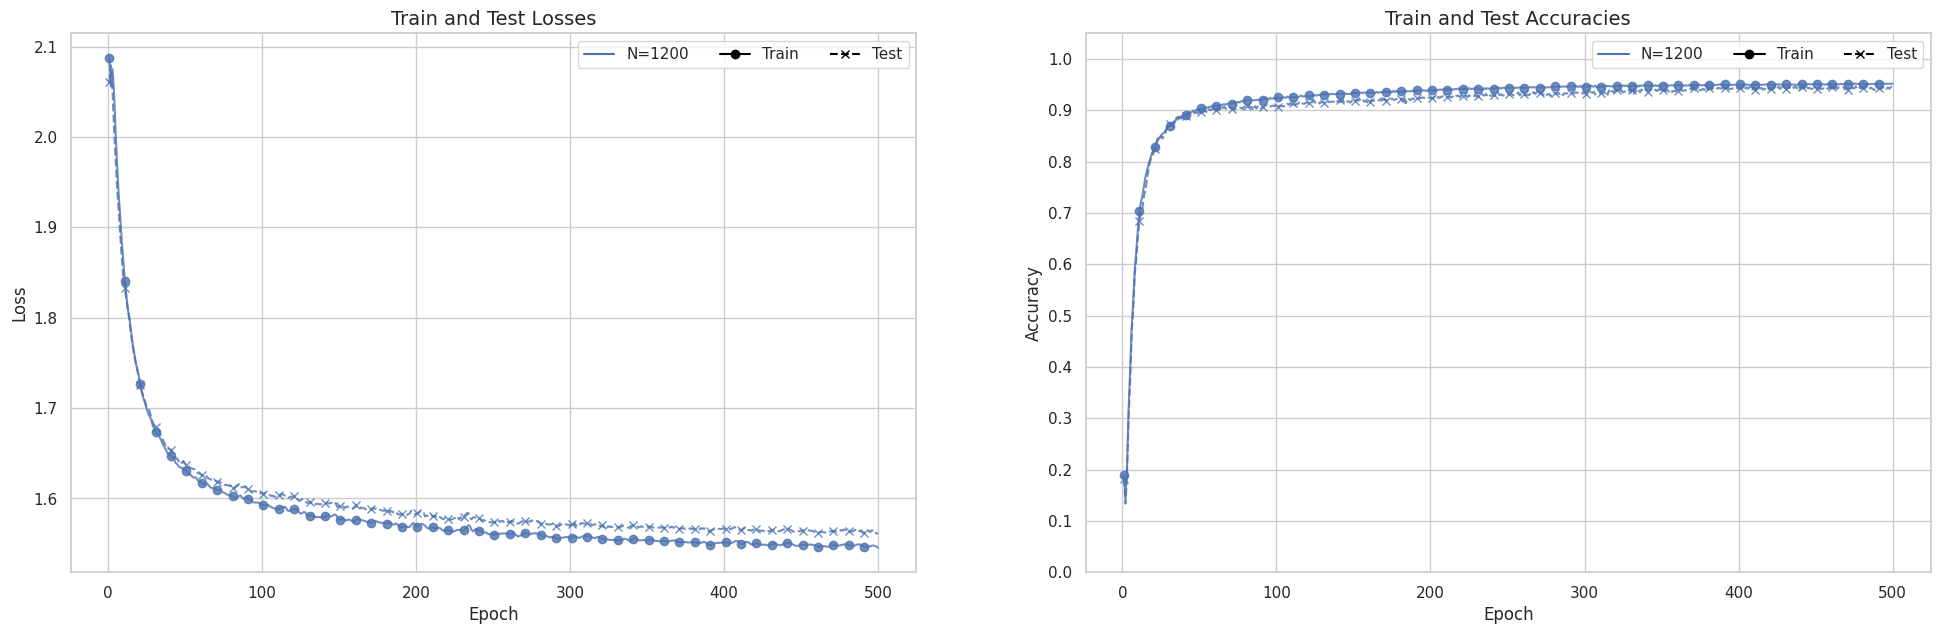

In [14]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)
ax.set_yticks(np.arange(0.0, 1.05, step=0.1))

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [ ]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/sklearn-digits-dataset"
results_df.to_csv(os.path.join(save_folder, "digits_HermImgReUpload_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "digits_HermImgReUpload_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "digits_HermImgReUpload_results.pdf"))

In [15]:
from google.colab import files

# Save the CSV files and the plot to the local file system
results_df.to_csv("digits_HermImgReUpload_results.csv")
df_agg.to_csv("digits_HermImgReUpload_results_agg.csv")
fig.savefig("digits_HermImgReUpload_results.pdf")

# Download the files to your PC
files.download("digits_HermImgReUpload_results.csv")
files.download("digits_HermImgReUpload_results_agg.csv")
files.download("digits_HermImgReUpload_results.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>